## Introduction to the project
Cars 4 You is an online car resale company that sells cars from multiple different brands.

Main goal -> expedite the evaluation process by creating a predictive model capable of evaluating the price of a car based on the user’s input without needing the car to be taken to a mechanic.

## Project Goals

1. Regression Benchmarking: Develop a regression model that accurately predicts car prices (price). 

2. Model Optimization: During your selection of best (or set of best) model(s), you are encouraged to explore ways to improve their performance (e.g. hyperparameter tuning or pre-processing/feature selection adjustments).

3. Additional Insights: This project segment is open-ended, meaning you can explore as many ideas as you desire (as long as you make them explicit and understandable). Here are some possible suggestions:

   a.Analyze and discuss the importance of the features for the different values of the target variable and how they contribute towards the prediction.

    b.Ablation Study: Measure the contribution of each element of the pipeline.

    c.Create an analytics interface that returns a prediction when new input data is provided.

    d.Test whether the best performance is achieved using a general model (trained using data from all brands/models, etc...) or using brand, model, fuel type, etc...-specific models.

    e.Determine whether training a Deep Learning network from scratch is moreeffective than fine-tuning a pre-trained model. 

## Tasks and Evaluations

1. Import the dataset and explore the data (3 points):
   
   a. Check data contents, provide descriptive statistics and check for inconsistencies in the data.
   
   b. Explore data visually and extract relevant insights. Explain your rationale and findings. Do not forget to analyse multivariate relationships.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from rapidfuzz import process, fuzz
import re
import numpy as np
from typing import Sequence, Mapping, Optional
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import category_encoders as ce

#wrapper methods and embedded methods 
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFECV, RFE

# Cross validation
from sklearn.model_selection import KFold, cross_val_score

# Linear regression models
from sklearn.ensemble import RandomForestRegressor

#Evaluation metrics
from sklearn.metrics import mean_squared_error

In [2]:
# Import train, test and samples submission data

train_car_data = pd.read_csv('/Users/diogotiberio/Documents/Mestrado Ciência de Dados IMS/1º Semestre/Machine Learning/Projeto/project_data/train.csv')

test_car_data = pd.read_csv('/Users/diogotiberio/Documents/Mestrado Ciência de Dados IMS/1º Semestre/Machine Learning/Projeto/project_data/test.csv')

sample_submission_car_data = pd.read_csv('/Users/diogotiberio/Documents/Mestrado Ciência de Dados IMS/1º Semestre/Machine Learning/Projeto/project_data/sample_submission.csv')

In [3]:
# chech to see if the train and test datasets were correctly imported
print("Train dataset:")
print(train_car_data.head())

print("Test dataset:")
print(test_car_data.head())

print("Samples submission dataset:")
print(sample_submission_car_data.head())

Train dataset:
   carID   Brand      model    year  price transmission  mileage fuelType  \
0  69512      VW       Golf  2016.0  22290    Semi-Auto  28421.0   Petrol   
1  53000  Toyota      Yaris  2019.0  13790       Manual   4589.0   Petrol   
2   6366    Audi         Q2  2019.0  24990    Semi-Auto   3624.0   Petrol   
3  29021    Ford     FIESTA  2018.0  12500        anual   9102.0   Petrol   
4  10062     BMW   2 Series  2019.0  22995       Manual   1000.0   Petrol   

     tax        mpg  engineSize  paintQuality%  previousOwners  hasDamage  
0    NaN  11.417268         2.0           63.0        4.000000        0.0  
1  145.0  47.900000         1.5           50.0        1.000000        0.0  
2  145.0  40.900000         1.5           56.0        4.000000        0.0  
3  145.0  65.700000         1.0           50.0       -2.340306        0.0  
4  145.0  42.800000         1.5           97.0        3.000000        0.0  
Test dataset:
    carID    Brand         model         year transm

In [4]:
train_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


The training dataset has 75973 entries and 14 columns 
There are some features with a significant fewer amount of entries: tax and mpg (we need to check for missing data and ways to repalce thoses missing data)
the carID column is going to be discarded.


##### Feature selection part:
Regarding data types, there are 8 features with datatype: float64, 2 features with int64 and 4 with object datatype
Estas 4 features com um object datatype são variáveis categóricas (representam texto ou categorias) e não podem ser utilizadas pelo modelo
Contudo, podemos saber a correlação entre elas através do chi-squared, que pode ser representado por um heat map.

Em relação às variáveis numéricas também podemos saber a correlção entre elas (Spearmam correlation, Pearson correlation, etc....)

If we want to try other features, we can use wrapper ou embeddeed methods.

In [5]:
test_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB


The test dataset has fewer entries that the train dataset, with only 32567 entries
Addicionally, it also has one less column (13 columns), being the price column
In this case we need to be carefull with data leakage, so we need to find a strategy to replace the missing values

Feature selection part
Regarding the datatypes, it has the same ones as the training dataset, so we need to apply the same strategies described above.

In [6]:
sample_submission_car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   carID   32567 non-null  int64
 1   price   32567 non-null  int64
dtypes: int64(2)
memory usage: 509.0 KB


In [7]:
# check the train_car_data for descriptive statistcs (with .describe()):
train_car_data.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
carID,75973.0,NaN,NaN,NaN,37986.0,21931.660338,0.0,18993.0,37986.0,56979.0,75972.0
Brand,74452,72,Ford,14808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
model,74456,735,Focus,6353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,74482.0,NaN,NaN,NaN,2017.096611,2.208704,1970.0,2016.0,2017.0,2019.0,2024.121759
price,75973.0,NaN,NaN,NaN,16881.889553,9736.926322,450.0,10200.0,14699.0,20950.0,159999.0
transmission,74451,40,Manual,38050,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mileage,74510.0,NaN,NaN,NaN,23004.184088,22129.788366,-58540.574478,7423.25,17300.0,32427.5,323000.0
fuelType,74462,34,Petrol,37995,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tax,68069.0,NaN,NaN,NaN,120.329078,65.521176,-91.12163,125.0,145.0,145.0,580.0
mpg,68047.0,NaN,NaN,NaN,55.152666,16.497837,-43.421768,46.3,54.3,62.8,470.8


From the descriptive statistics in the train data: 
The first thing we see is that all of the statistics in the hasDamage column are 0. This means that the cars have no damage, and this columns doesn't give significant information to the model so it can be discarted
Regarding the price, the max value (159999.000000) is sgnificantly higher that the 75th percentile (Q3 -> 20950.000000), this indicates the presence of outliers
The same thing happens to the millage (Q3 -> 32427.500000 and max -> 323000.000000). Furthermore, the min value is negative, which is not possible because we can have negative milage (-58540.574478)
In the tax, mpg and previousOwners we also have negative minimum values (not possible), this also means we have outliers in these columns

To remove the outliers we need the interquartile range (IQR) to set the lower and upper limits

In the pre-processing we also can log_scaling the numeric values in price and also milage.

All off this part is going to be done in part 2

In [8]:
# check the test_car_data for descriptive statistcs:
test_car_data.describe()

# We have the same exact thing as in the train_car_data   

,carID,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
count,32567.000000,31914.000000,31878.000000,29259.000000,29279.000000,31939.000000,31942.000000,31970.000000,31970.0
mean,92256.000000,2017.102299,22952.658921,120.569239,55.210728,1.665377,64.446667,2.006118,0.0
std,9401.427445,2.207969,22132.758713,65.560570,17.644635,0.574467,21.142188,1.472310,0.0
min,75973.000000,1991.000000,-58540.574478,-91.121630,-43.421768,-0.103493,1.638913,-2.345650,0.0
25%,84114.500000,2016.000000,7298.250000,125.000000,46.300000,1.200000,47.000000,1.000000,0.0
50%,92256.000000,2017.000000,17225.500000,145.000000,54.300000,1.600000,65.000000,2.000000,0.0
75%,100397.500000,2019.000000,32500.000000,145.000000,62.800000,2.000000,82.000000,3.000000,0.0
max,108539.000000,2024.121759,279000.000000,580.000000,470.800000,6.600000,125.594308,6.258371,0.0


### Data Visualization

#### Numeric Variables 
-> Histograms to see the distribuition and to make decision on how to replace the missing values (if we replace them with the mean or the median)

-> Boxplots to see the presence of outliers that should be removed because they affect the linear regression models prediction

-> Scatter plots to see the correlation between numerical features

In [9]:
# since we are going to replace with the missing values in the train and test car data with the mean or median of the train dataset to avoid data leakage
# we are only visualize the de train car data plots

train_car_data_cp = train_car_data.copy()

numerical_train_data = train_car_data_cp.select_dtypes(include=["int64", "float64"]).drop("carID", axis=1)
numerical_train_data_col = numerical_train_data.columns

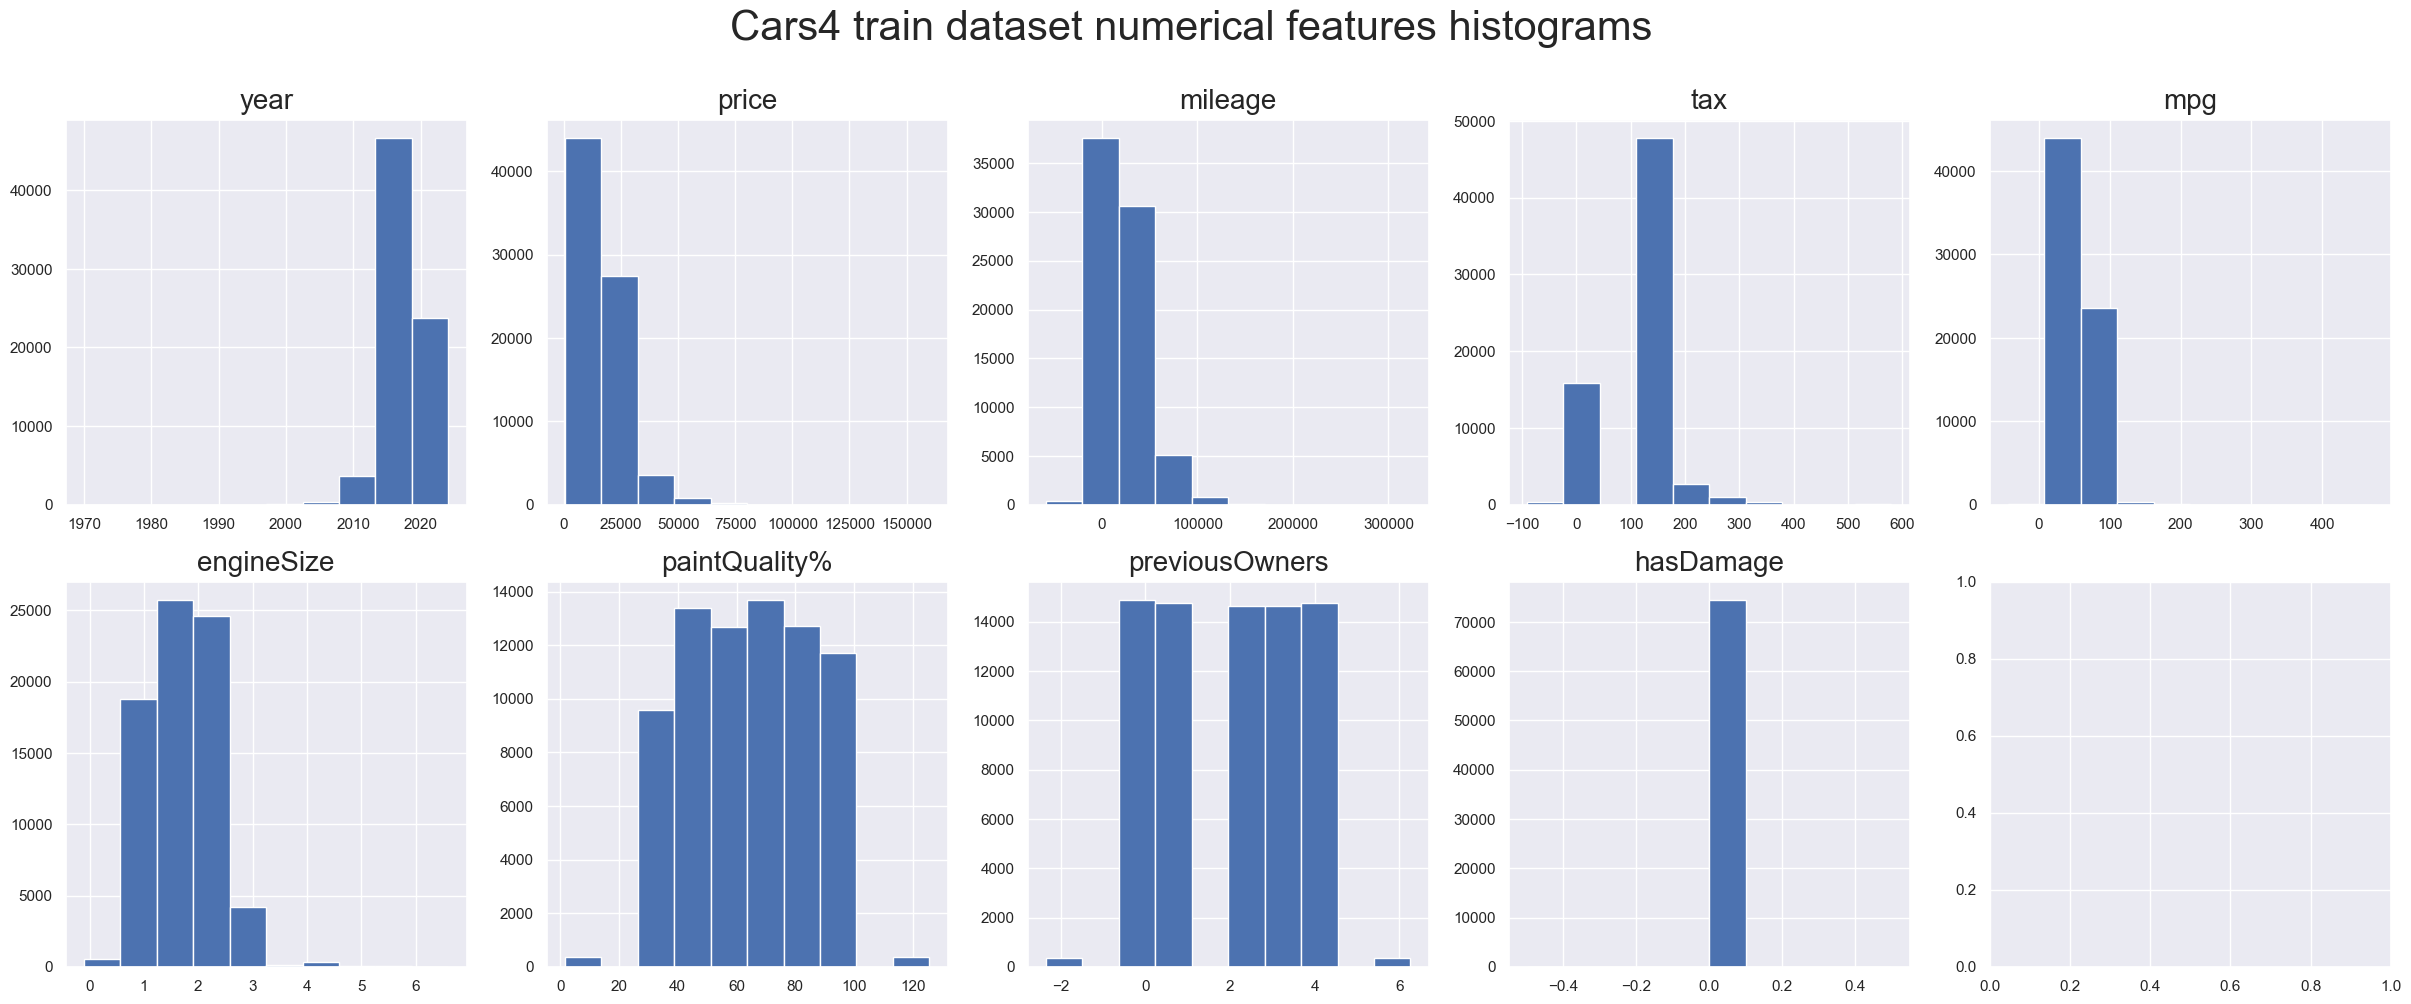

In [10]:
# histograms 

sns.set()

# create individual axes for each one of the histograms 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 11)) 

for ax, feature in zip(axes.flatten(), numerical_train_data_col):
    ax.hist(train_car_data_cp[feature], bins=10) # we set the number of bins to 10 to see the distribution better
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 train dataset numerical features histograms", fontsize=30)
plt.show()

From the histograms of numerical features we can see that price, mileage, tax, mpg and engineSize are skeweed to the right, whereas year is skeweed to the left. In all of this cases we are going to use the median as the statictics to fill the missing data in these columns, because the median is less sensitive to outliers that the mean. Regarding the other 3 features, for paintQuality% and previousOwners we can use the mean, because they seem to follow a more normal distribution and the hasDamage feature we can repalce the missing values with zero, since all the values are zero (also seen in the descriptive statistics).

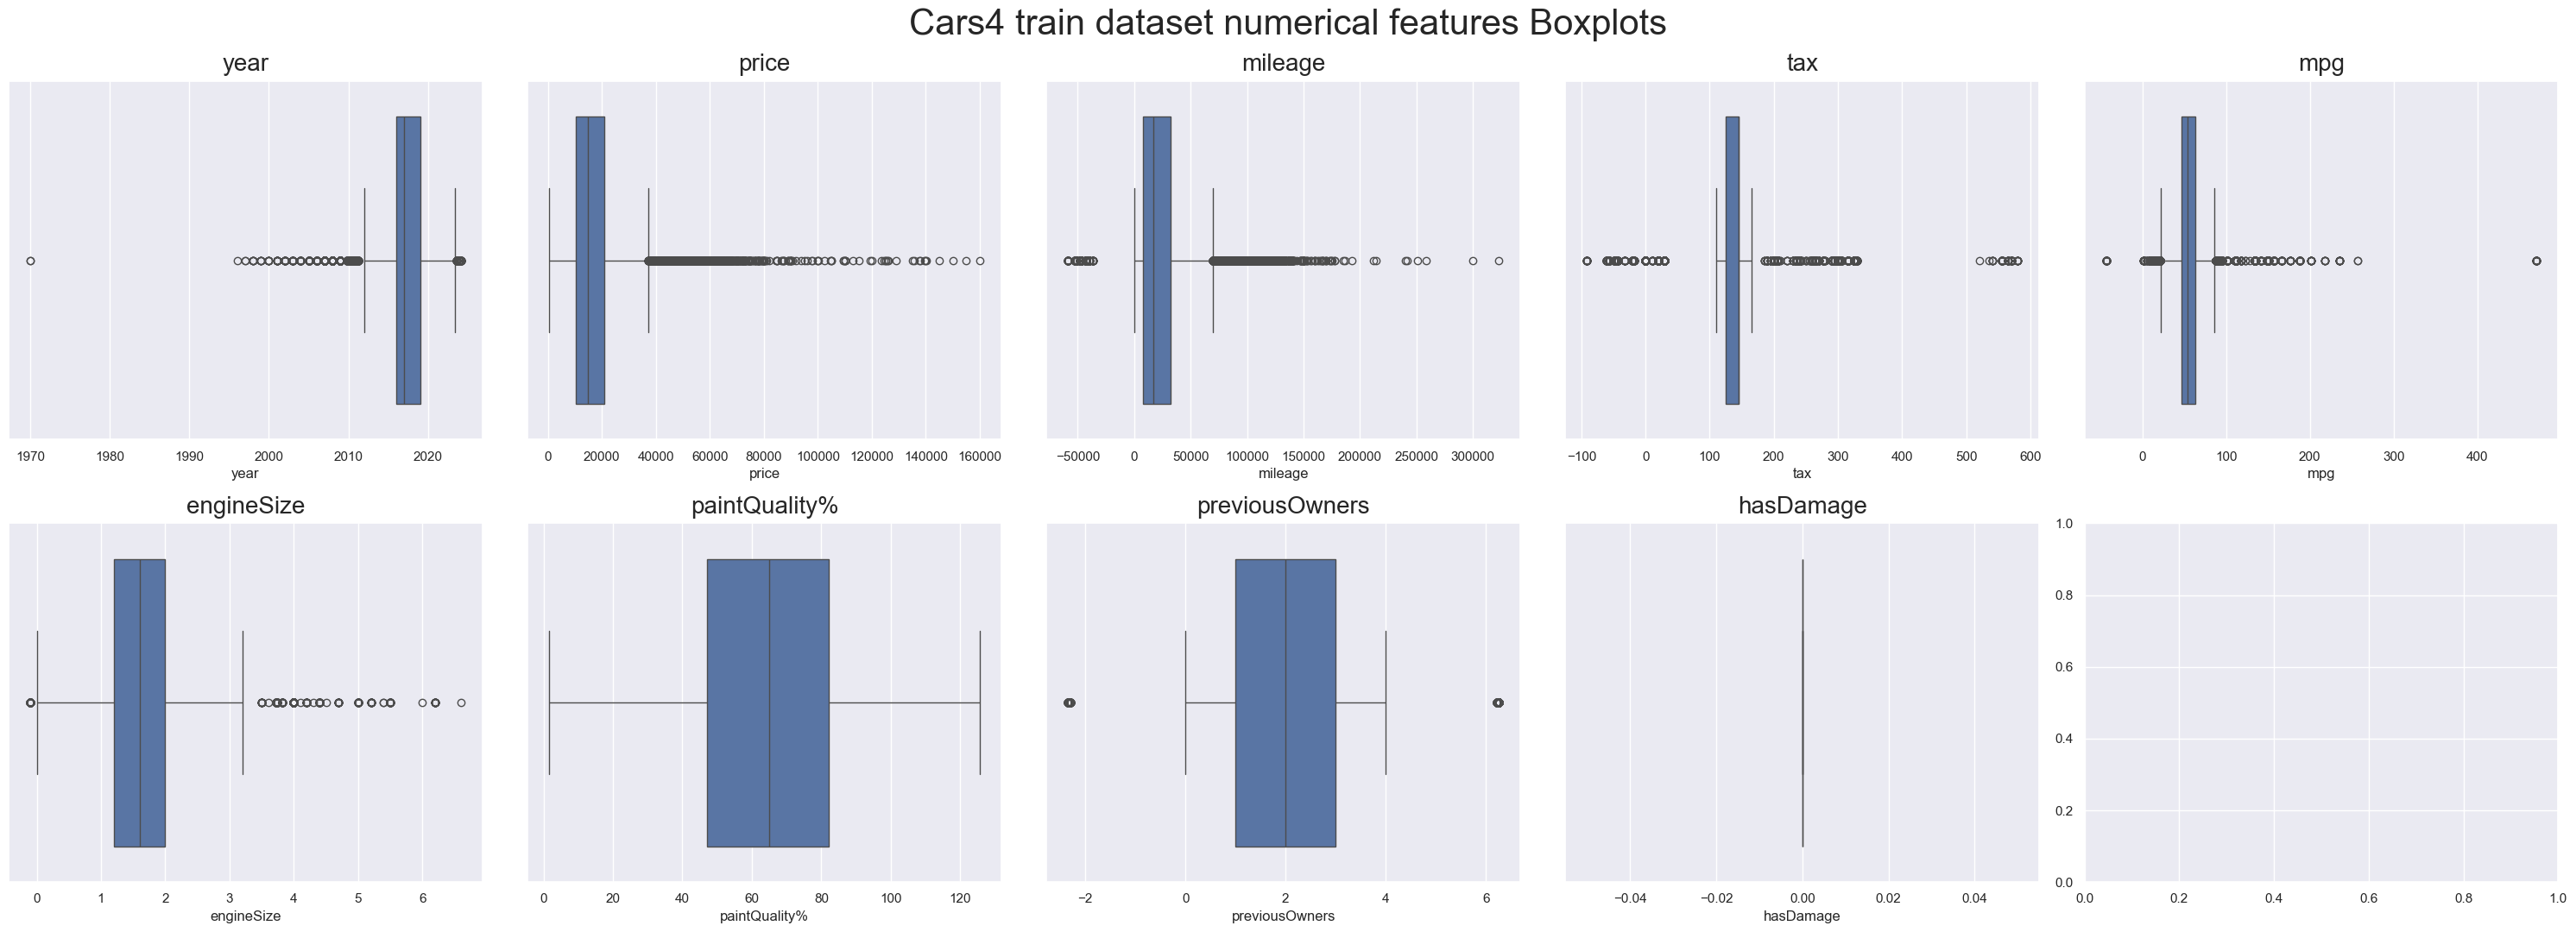

In [11]:
# boxplot train data

sns.set()

# create individual axes for each one of the boxplots 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 11), tight_layout=True) 

# Iterate over each one of the elements and plot their boxplots
for ax, feature in zip(axes.flatten(), numerical_train_data_col):
    sns.boxplot(x=train_car_data_cp[feature], ax=ax)
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 train dataset numerical features Boxplots", fontsize=30)    

plt.show()


As stated in the descritive statistcs, the year, price, mileage, tax, mpg, and engineSize features have a significante number of outliers. We could remove them, however, we would lost a lost of data so for eacg feature we can apply a mask and define the limit for outliers ourselfs, with this strategy we are remove the more significant outliers while preserving most of the data. 

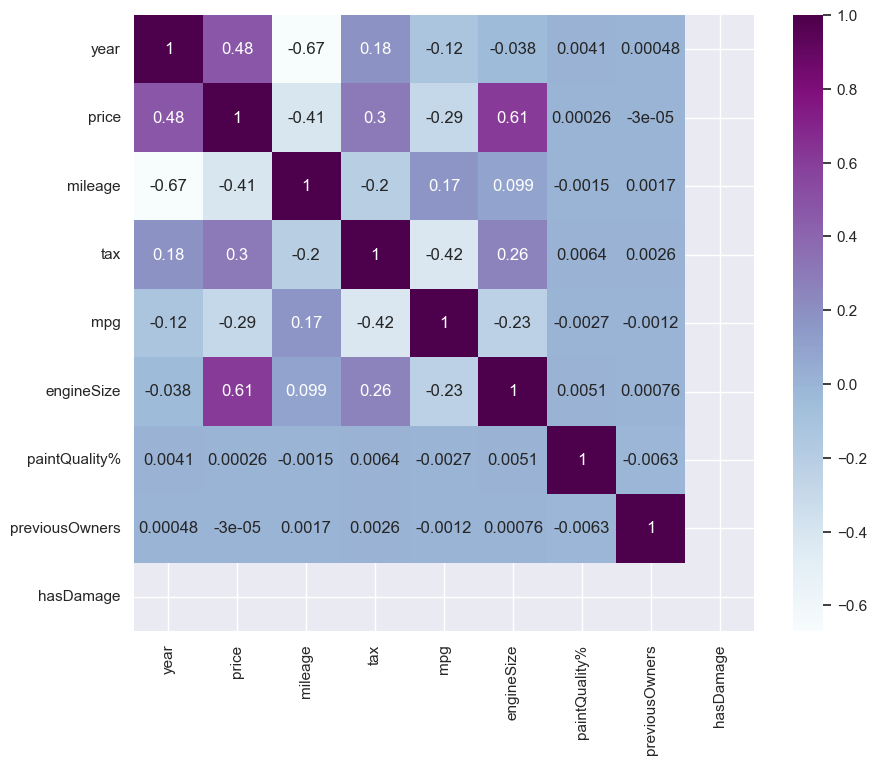

In [12]:
# Correlation matrix

num_correlation = numerical_train_data.corr() # default method is pearson correlation

plt.figure(figsize=(10,8))
sns.heatmap(data = num_correlation, annot = True, cmap="BuPu")
plt.show()

From this preleminary analysis there seems that features price and year and features price and engineSize have positive correlation (correlatio of 0.48 and 0.61 respectively), while features mileage and year; milage and price; and tax and mpg have negative correlation (-0.67, -0.41 and -0.42). These features could be important for the feature selection part since have ideial positive and negative correlation without having to high or to low of a correlation to make them irrelevant oe redundant.

#### Categorical variables 

-> Boxplots so see any inconsistencies in the data

In [13]:
categorical_train_data = train_car_data_cp.select_dtypes(include="object")
categorical_train_data_col = categorical_train_data.columns
categorical_train_data_col

Index(['Brand', 'model', 'transmission', 'fuelType'], dtype='object')

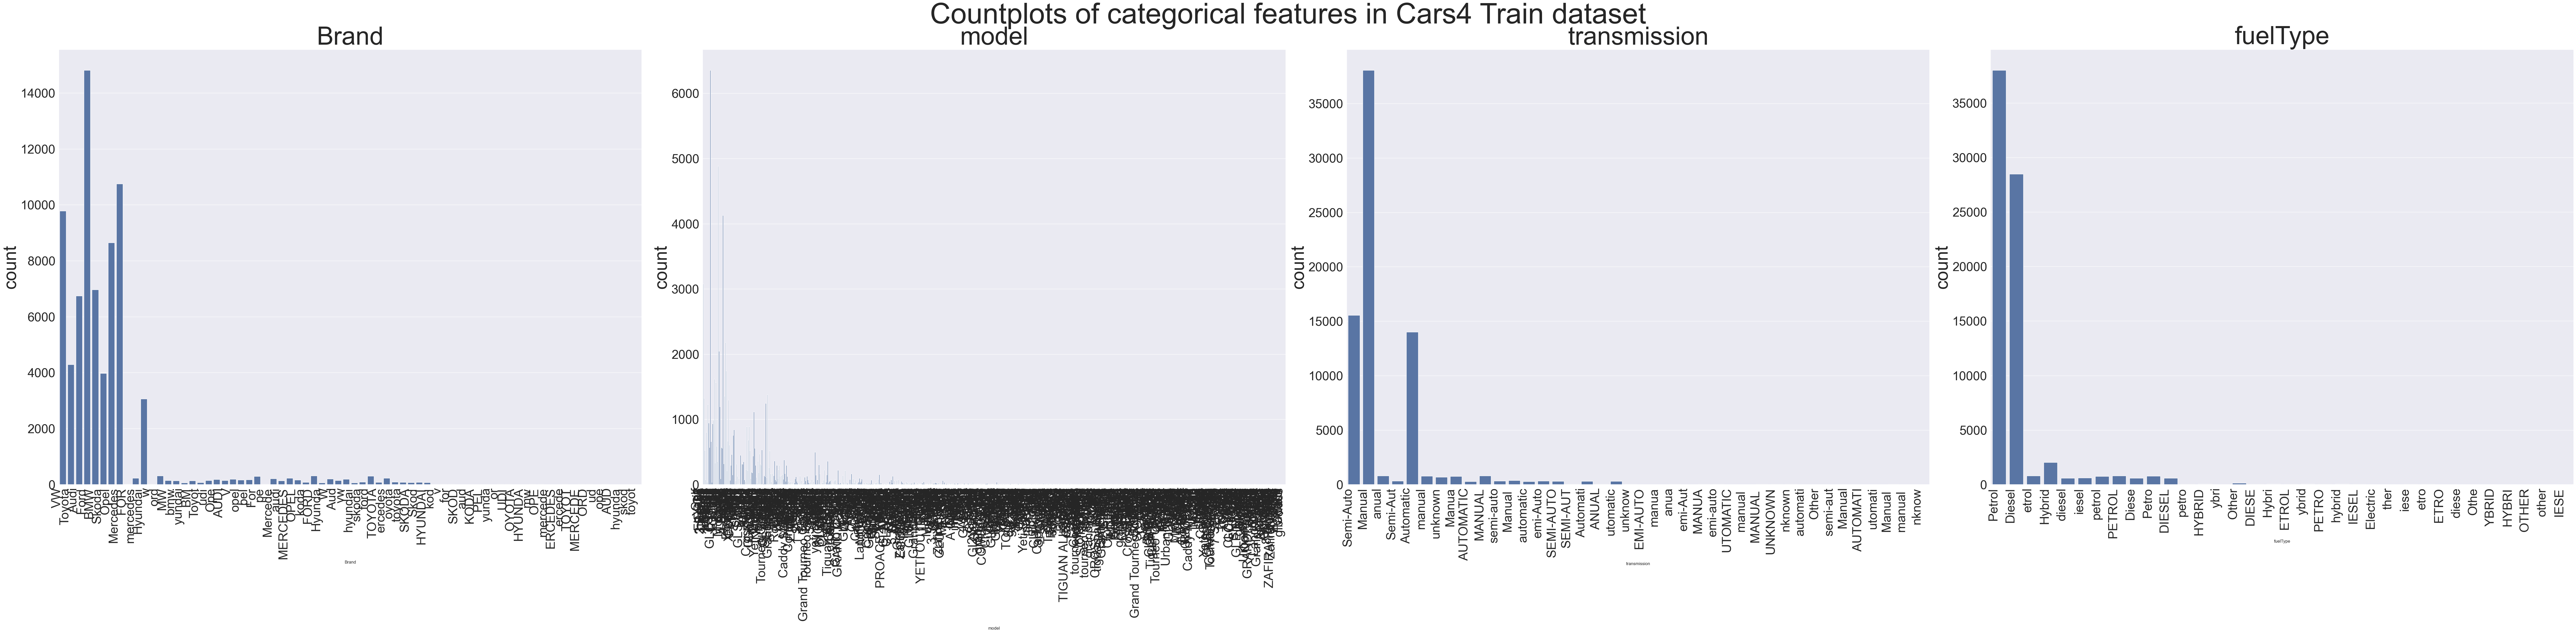

In [14]:
sns.set()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(100, 25), tight_layout=True)

for ax, feature in zip(axes.flatten(), categorical_train_data_col):
    sns.countplot(data=train_car_data_cp, x=feature, ax=ax)
    ax.set_title(feature, fontsize=70, pad=8)

    ax.set_ylabel("count", fontsize=50)

    ax.tick_params(axis='both', labelsize=35)

    plt.setp(ax.get_xticklabels(), rotation=90, ha='right')


fig.set_constrained_layout_pads(wspace=0.1, hspace=0.15, w_pad=0.4, h_pad=0.3)
plt.suptitle("Countplots of categorical features in Cars4 Train dataset", fontsize=80)
plt.show()

In all categorical features there are data inconsistencies(a lot of names are misspelled). We need to change these inconsistencies in part 2.

### 2º part- Clean and pre-process the dataset
In this part we need to check for:

1. Are there any missing values? Take action to handle them.
2. Check the dataset for outliers and pre-process them. Justify your decisions.
3. Deal with categorical variables.
4. Review current features and create extra features if needed. Explain your steps.
5. Perform data scaling. Explain the reasoning behind your choices.

#### 1. Identify and fill missing data in numeric features

In [15]:
test_car_data_cp = test_car_data.copy()

In [16]:
# Identify missing values in the train data

missing_values_train = train_car_data_cp.isna().sum()
missing_values_train

carID                0
Brand             1521
model             1517
year              1491
price                0
transmission      1522
mileage           1463
fuelType          1511
tax               7904
mpg               7926
engineSize        1516
paintQuality%     1524
previousOwners    1550
hasDamage         1548
dtype: int64

Almost every feature has a substancial amount of missing data, so it's not the best decision to remove all the rows that have missing values beacuse we are going to loss a lot of information and data. As previosly mention, the missing values of the numeric features year, mileage, tax, mpg, and engineSize are going to be filled by the median, whereas the missing values of paintQuality% and previousOwners  are going to be replaced with the mean. Finally, hasDamage missing values are going to be replaced by 0.

In [17]:
# Identify missing values in the test data

missing_values_test = test_car_data_cp.isna().sum()
missing_values_test

carID                0
Brand              649
model              650
year               653
transmission       623
mileage            689
fuelType           656
tax               3308
mpg               3288
engineSize         628
paintQuality%      625
previousOwners     597
hasDamage          597
dtype: int64

In [18]:
# Handling missing values in numeric features 
# year, mileage, tax, mpg, and engineSize -> median
# paintQuality% and previousOwners -> mean
# hasDamage -> 0
# The missing values in the test dataset are also going to be fill with the train median or mean 


for feature in numerical_train_data_col.drop("price"):
    if feature in ["year", "mileage", "tax", "mpg", "engineSize"]:
        train_feature_median = train_car_data_cp[feature].median()
        
        # fill the missing values in train dataset with train median
        train_car_data_cp[feature].fillna(train_feature_median, inplace=True)
        
        # fill the missing values in test dataset with train median
        test_car_data_cp[feature].fillna(train_feature_median, inplace=True)

    elif feature in ["paintQuality%", "previousOwners"]:
        train_feature_mean = train_car_data_cp[feature].mean()

        train_car_data_cp[feature].fillna(train_feature_mean, inplace=True)

        test_car_data_cp[feature].fillna(train_feature_mean, inplace=True)

    elif feature in ["hasDamage"]:
        train_car_data_cp[feature].fillna(0, inplace=True)

        test_car_data_cp[feature].fillna(0, inplace=True)

/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_5069/2524737389.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_car_data_cp[feature].fillna(train_feature_median, inplace=True)
/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_5069/2524737389.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we ar

In [19]:
missing_values_train_2 = train_car_data_cp.isna().sum()
missing_values_train_2

carID                0
Brand             1521
model             1517
year                 0
price                0
transmission      1522
mileage              0
fuelType          1511
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
hasDamage            0
dtype: int64

In [20]:
missing_values_test_2 = test_car_data_cp.isna().sum()
missing_values_test_2

carID               0
Brand             649
model             650
year                0
transmission      623
mileage             0
fuelType          656
tax                 0
mpg                 0
engineSize          0
paintQuality%       0
previousOwners      0
hasDamage           0
dtype: int64

#### 2. Deal with categorical variables (misspelling and missing values)

-> In the case of categorical features we can use the mode or use k-nearest neighbours method to fill the issing values with similar records (Verificar se podemos fazer isto). However we still need to treat the misspelled name before proceding to the missing values

In [21]:
# iterate over all the categorical features to check for inconsistances in the training data 

for category in categorical_train_data_col:
    print(category)
    print(train_car_data_cp[category].unique())

Brand
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'
 'OPEL' 'koda' 'FORD' 'Hyunda' 'W' 'Aud' 'vw' 'hyundai' 'skoda' 'ford'
 'TOYOTA' 'ercedes' 'oyota' 'toyota' 'SKODA' 'Skod' 'HYUNDAI' 'kod' 'v'
 'for' 'SKOD' 'aud' 'KODA' 'PEL' 'yunda' 'or' 'UDI' 'OYOTA' 'HYUNDA' 'mw'
 'OPE' 'mercede' 'ERCEDES' 'ercede' 'TOYOT' 'MERCEDE' 'ORD' 'ud' 'ope'
 'AUD' 'hyunda' 'skod' 'toyot']
model
[' Golf' ' Yaris' ' Q2' ' FIESTA' ' 2 Series' '3 Series' ' A3' ' Octavia'
 ' Passat' ' Focus' ' Insignia' ' A Clas' ' Q3' ' Fabia' ' A Class' ' Ka+'
 ' 3 Series' ' GLC Class' ' I30' ' C Class' ' Polo' ' E Class' ' C Clas'
 ' Q5' ' Up' ' Fiesta' ' C-HR' ' Mokka X' ' Corsa' ' Astra' ' TT'
 ' 5 Series' ' Aygo' ' 4 Series' ' SLK' ' Viva' ' T-Roc' 'Focus'
 ' EcoSport' ' Tucson' ' EcoSpor' nan ' X-CLASS' ' CL Class' ' IX20'
 ' i20' ' Rapid' ' a1' ' Auris' ' 

When checking the categorical features we can see a lot of inconsistances in the data:

-> There are a lot of brand that are wrong (ex: mercedes, MERCEDES, ERCEDES, mercede, etc)

-> In the model feature we have nan (we need to swap them for "")

-> In the transmission and Fueltype we also have a lot of inconsistances

In [22]:
def normalize_string(string: str) -> str:
    string = str(string).lower().strip()
    return re.sub(r"[^a-z0-9]+", "", string) # removes spaces


def fuzzy_fix(x: object, correct_names: Sequence[str], aliases: Optional[Mapping[str, str]] = None,  cutoff: int = 80):

    # creates a dict with the normalized strings as the keys and the not normalized strings as values from the input list
    canon_map = {normalize_string(label): label for label in correct_names}
    # create a list with only the keys (normalized strings)
    choice_keys = list(canon_map.keys())

    normalized_name = normalize_string(x)

    # Normalize alias keys too; alias values should be canonical brands
    if aliases:
        alias_normalized = {normalize_string(key): value for key, value in aliases.items()}
        if normalized_name in alias_normalized:
            return alias_normalized[normalized_name]

    # if the normalized string is already the correct name return it
    if normalized_name in canon_map:
        return canon_map[normalized_name]

    # it the normalized string doesn't correct to the correct name the use fuzzy match to match the name to the correct one
    match = process.extractOne(normalized_name, choice_keys, scorer=fuzz.WRatio, score_cutoff=cutoff)
    return canon_map[match[0]] if match else np.nan # returns the match with the highest similarity score

In [23]:
# correct the misspelled names in the brands column

brands_list = ["Volkswagen", "Toyota", "Audi", "Ford", "BMW", "Skoda", "Opel", "Mercedes", "Hyundai"]
brands_aliases = {"vw":"Volkswagen","v":"Volkswagen","merc":"Mercedes","bm":"BMW"}

train_car_data_cp["Brand"] = train_car_data_cp["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
train_car_data_cp["Brand"].unique()

# Do the same for the test datadf

array(['Volkswagen', 'Toyota', 'Audi', 'Ford', 'BMW', 'Skoda', 'Opel',
       'Mercedes', 'Hyundai', nan], dtype=object)

In [24]:
test_car_data_cp["Brand"] = test_car_data_cp["Brand"].map(lambda brand: fuzzy_fix(brand, brands_list, brands_aliases, cutoff=84))
test_car_data_cp["Brand"].unique()

array(['Hyundai', 'Volkswagen', 'BMW', 'Opel', 'Ford', 'Mercedes',
       'Skoda', 'Toyota', 'Audi', nan], dtype=object)

In [25]:
# correct the misspelled names in the transmission column

transmissions_list = ["Manual","Automatic","Semi-Automatic", "Other", "Unkown"]
transmissions_alises = {"mt":"Manual","man":"Manual","auto":"Automatic","at":"Automatic","dsg":"Automatic"}

train_car_data_cp["transmission"] = train_car_data_cp["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
train_car_data_cp["transmission"].unique()

# Do the same for the test datadf
# in the case of transmissions we can replace the missing values with Unkown

array(['Semi-Automatic', 'Manual', 'Automatic', nan, 'Unkown', 'Other'],
      dtype=object)

In [26]:
test_car_data_cp["transmission"] = test_car_data_cp["transmission"].map(lambda transmission: fuzzy_fix(transmission, transmissions_list, transmissions_alises, cutoff=82))
test_car_data_cp["transmission"].unique()

array(['Automatic', 'Semi-Automatic', 'Manual', 'Unkown', nan, 'Other'],
      dtype=object)

In [27]:
# correct the misspelled names in the fuel type column

fueltype_list = ["Petrol", "Diesel", "Hybrid", "Electric", "Other"]

train_car_data_cp["fuelType"] = train_car_data_cp["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
train_car_data_cp["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [28]:
test_car_data_cp["fuelType"] = test_car_data_cp["fuelType"].map(lambda fueltype: fuzzy_fix(fueltype, fueltype_list, cutoff=82))
test_car_data_cp["fuelType"].unique()

array(['Petrol', 'Diesel', 'Hybrid', nan, 'Other', 'Electric'],
      dtype=object)

In [29]:
# Do the same for the car models columns
MODEL_BY_BRAND = {
    'Audi': ['A', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'Q', 'Q2', 'Q3', 'Q5', 'Q7', 'Q8', 'RS', 'RS3', 'RS4', 'RS5', 'RS6', 'S', 'S1', 'S3', 'S4', 'S5', 'S6', 'SQ2', 'SQ5', 'TT', 'e-tron'],
    'BMW': ['1 Series', '2 Series', '3 Serie', '3 SERIES', '3 Series', '4 Series', '5 Serie', '5 Series', '7 Series', '8 Series', 'M2', 'M3', 'M4', 'M5', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'Z4', 'i3', 'i4'],
    'Ford': ['B-MAX', 'C-MAX', 'Ecosport', 'Edge', 'Fiesta', 'Focus', 'Galaxy', 'Ka', 'Kuga', 'Mondeo', 'Mustang', 'Puma', 'S-MAX', 'Tourneo', 'Transit'],
    'Hyundai': ['Accent', 'Getz', 'I1', 'I10', 'I2', 'I20', 'I3', 'I30', 'I40', 'I80', 'I800', 'IONIQ', 'Kona', 'Santa Fe', 'Tucson'],
    'Mercedes': ['A-Class', 'AMG GT', 'B-Class', 'C-Class', 'CLA', 'CLK', 'CLS', 'Citan', 'E-Class', 'GLA', 'GLB', 'GLC', 'GLE', 'GLK', 'GLS', 'M-Class', 'S-Class', 'GLC-Class', 'SL', 'SLC', 'SLK', 'Sprinter', 'V-Class', 'Vaneo', 'Viano'],
    'Opel': ['Adam', 'Astra', 'Corsa', 'Crossland', 'Grandland', 'Insignia', 'Karl', 'Meriva', 'Mokka', 'Vectra', 'Zafira'],
    'Skoda': ['Citigo', 'Enyaq', 'Fabia', 'Kamiq', 'Karoq', 'Kodiaq', 'Octavia', 'Rapid', 'Roomster', 'Scala', 'Superb', 'Yeti'],
    'Toyota': ['Auris', 'Avensis', 'Aygo', 'C-HR', 'Camry', 'Corolla', 'GT86', 'RAV4', 'Verso', 'Yaris'],
    'Volkswagen': ['Arteon', 'Beetle', 'Bora', 'Caddy', 'CC', 'Crafter', 'Eos', 'Fox', 'Golf', 'Golf Plus', 'ID.3', 'ID.4', 'Jetta', 'Lupo', 'Passat', 'Phaeton', 'Polo', 'Scirocco', 'Sharan', 'T-Cross', 'T-Roc', 'Tiguan', 'Touareg', 'Touran', 'Transporter', 'Up'],
}


def fix_car_models(raw_model_names: str, cleaned_brand_names):

    candidates = MODEL_BY_BRAND.get(cleaned_brand_names)
    
    if not candidates:
        # fallback to all models if brand unknown
        candidates = sorted({m for lst in MODEL_BY_BRAND.values() for m in lst})
    
    # token_set_ratio handles word order/extra tokens well
    return fuzzy_fix(raw_model_names, candidates, aliases=None, cutoff=86)

In [30]:
train_car_data_cp["model"] = train_car_data_cp.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
train_car_data_cp["model"].unique()

array(['Golf', 'Yaris', 'Q2', 'Fiesta', '2 Series', '3 Series', 'A3',
       'Octavia', 'Passat', 'Focus', 'Insignia', 'A-Class', 'Q3', 'Fabia',
       'Ka', 'GLC-Class', 'I30', 'C-Class', 'Polo', 'E-Class', nan, 'Q5',
       'Up', 'C-HR', 'Mokka', 'Corsa', 'Astra', 'TT', '5 Series', 'Aygo',
       '4 Series', 'SLK', 'T-Roc', 'Ecosport', 'Tucson', 'CLA', 'I20',
       'Rapid', 'A1', 'Auris', 'Sharan', 'Adam', 'X3', 'A8', 'B-MAX',
       'A4', 'Kona', 'I10', 'S-MAX', 'X2', 'Crossland', 'Tiguan', 'A5',
       'Zafira', 'IONIQ', 'A6', 'Mondeo', 'Yeti', 'X1', 'Scala',
       'S-Class', '1 Series', 'Kamiq', 'Kuga', 'Tourneo', 'Q7', 'Arteon',
       'Santa Fe', 'Grandland', 'I800', 'RAV4', 'Touran', 'Citigo',
       'Roomster', 'Corolla', 'B-Class', 'Q', 'Kodiaq', 'V-Class', 'A',
       'Caddy', 'Superb', 'Getz', 'Beetle', 'Galaxy', 'M3', 'X4',
       '3 Serie', 'M4', 'Z4', 'X5', 'Meriva', 'RS6', 'Verso', 'Touareg',
       'C-MAX', 'Puma', 'I40', 'Karoq', 'I3', 'T-Cross', 'A7',
       'Golf 

In [31]:
test_car_data_cp["model"] = test_car_data_cp.apply(lambda r: fix_car_models(r["model"], r["Brand"]), axis=1)
test_car_data_cp["model"].unique()

array(['I30', 'Tiguan', '2 Series', 'Grandland', '1 Series', 'Fiesta',
       'X1', 'B-Class', 'Focus', 'Superb', '5 Series', 'C-Class', 'Up',
       'Aygo', 'Golf', 'M-Class', nan, 'TT', 'Adam', 'Zafira', 'E-Class',
       '3 Series', 'A4', 'Yaris', 'Passat', 'I10', 'Mokka', 'Ecosport',
       '4 Series', 'A7', 'Corsa', 'Kuga', 'C-MAX', 'Q2', 'M4', 'A-Class',
       'RAV4', 'Fabia', 'Insignia', 'A1', 'X6', 'Meriva', 'Octavia',
       'Auris', 'CLA', 'Astra', 'V-Class', 'Polo', 'Karoq', 'Q5',
       'Tucson', 'A3', 'S-Class', 'Corolla', 'Ka', 'X3', 'I40', 'I20',
       'Kamiq', 'Crossland', 'Q3', 'Galaxy', 'X2', 'Kodiaq', 'GLC-Class',
       'Mondeo', 'Touran', 'X5', 'Verso', 'Touareg', 'T-Roc', 'Q', 'A5',
       'Scirocco', 'X7', 'B-MAX', '8 Series', 'A', 'A6', 'Santa Fe',
       'Beetle', 'X4', 'Sharan', 'Golf Plus', 'A8', 'Kona', 'Citigo',
       'Rapid', '3 Serie', 'SLK', 'Yeti', 'Q7', 'C-HR', 'M5', 'T-Cross',
       'Avensis', 'IONIQ', 'Z4', 'M2', 'M3', 'Arteon', 'Scala', 'Puma',


In [32]:
# for the missing values we can replace them with Unkown in the brand name, transmission and Other in the fueltype

for numerical_col in categorical_train_data_col.drop("model"):
    if numerical_col in ["Brand", "transmission"]:
        train_car_data_cp[numerical_col].fillna("Unkown", inplace=True)
        test_car_data_cp[numerical_col].fillna("Unkown", inplace=True)
    else:
        train_car_data_cp[numerical_col].fillna("Other", inplace=True)
        test_car_data_cp[numerical_col].fillna("Other", inplace=True)

/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_5069/2015962113.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_car_data_cp[numerical_col].fillna("Unkown", inplace=True)
/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_5069/2015962113.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [33]:
# check the missing values 
train_car_data_cp.isna().sum()

carID                0
Brand                0
model             3043
year                 0
price                0
transmission         0
mileage              0
fuelType             0
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
hasDamage            0
dtype: int64

In [34]:
test_car_data_cp.isna().sum()

carID                0
Brand                0
model             1285
year                 0
transmission         0
mileage              0
fuelType             0
tax                  0
mpg                  0
engineSize           0
paintQuality%        0
previousOwners       0
hasDamage            0
dtype: int64

In [35]:
# Since the missing values rate for the model are less then 5% we can eliminate the rows or assign them to Unkown.

In [36]:
train_car_data_cp["model"].fillna("Unkown", inplace=True)
test_car_data_cp["model"].fillna("Unkown", inplace=True)

/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_5069/1502320581.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_car_data_cp["model"].fillna("Unkown", inplace=True)
/var/folders/f0/h1r1t1l15cz_0gjkxj_2n_qr0000gn/T/ipykernel_5069/1502320581.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

In [37]:
print(train_car_data_cp.isna().sum())
print(test_car_data_cp.isna().sum())

carID             0
Brand             0
model             0
year              0
price             0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64
carID             0
Brand             0
model             0
year              0
transmission      0
mileage           0
fuelType          0
tax               0
mpg               0
engineSize        0
paintQuality%     0
previousOwners    0
hasDamage         0
dtype: int64


In [38]:
# In the transmission part we have both Unkown and Other -> Need to see which one is more fitting to replace the missing values

After the treatment of the misspelled data and missing values in the categorical data we need to convert the categorical features into numerical because we can input categorical features to the model. We can do this step after the feature selection part, so we only need to implement this change haver we determine each features are relevant.

#### Handling outliers

As previously stated, most of the numerical variables have a significant number of outliers. One possibility is to calculate the interquartile range (iqr) and define the minimum and maximum tresholds, however this could result in the elimination of a lot of information. For this reason we can apply a mask and define the treshold ourself. 

-> As a rule of thumb we shouldn't delete more than 5% of the rows

In [39]:
# First we are going to manually set the bounds for outliers

train_cars_mask = (
    (train_car_data_cp["year"] >= 2005)
    &
    (train_car_data_cp["price"] <= 80000)
    &
    (train_car_data_cp["mileage"].between(0, 150_000))
    &
    (train_car_data_cp["tax"].between(0, 300))
    &
    (train_car_data_cp["mpg"].between(0, 150))
    &
    (train_car_data_cp["engineSize"].between(0, 5))
    &
    (train_car_data_cp["previousOwners"] >= 0)
) # the other 2 numerical columns don't need a mask

train_cars_filter_out = train_car_data_cp[train_cars_mask]
train_cars_filter_out.head()

,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,69512,Volkswagen,Golf,2016.0,22290,Semi-Automatic,28421.000000,Petrol,145.0,11.417268,2.0,63.0,4.0,0.0
1,53000,Toyota,Yaris,2019.0,13790,Manual,4589.000000,Petrol,145.0,47.900000,1.5,50.0,1.0,0.0
2,6366,Audi,Q2,2019.0,24990,Semi-Automatic,3624.000000,Petrol,145.0,40.900000,1.5,56.0,4.0,0.0
4,10062,BMW,2 Series,2019.0,22995,Manual,1000.000000,Petrol,145.0,42.800000,1.5,97.0,3.0,0.0
5,14704,BMW,3 Series,2014.0,8199,Manual,101153.348285,Diesel,30.0,65.700000,2.0,74.0,0.0,0.0


In [40]:
print('Percentage of train data kept after manually removing outliers:', np.round(train_cars_filter_out.shape[0] / train_car_data_cp.shape[0], 4))

Percentage of train data kept after manually removing outliers: 0.9714


##### We only remove a total of around 2% of rows in the train data

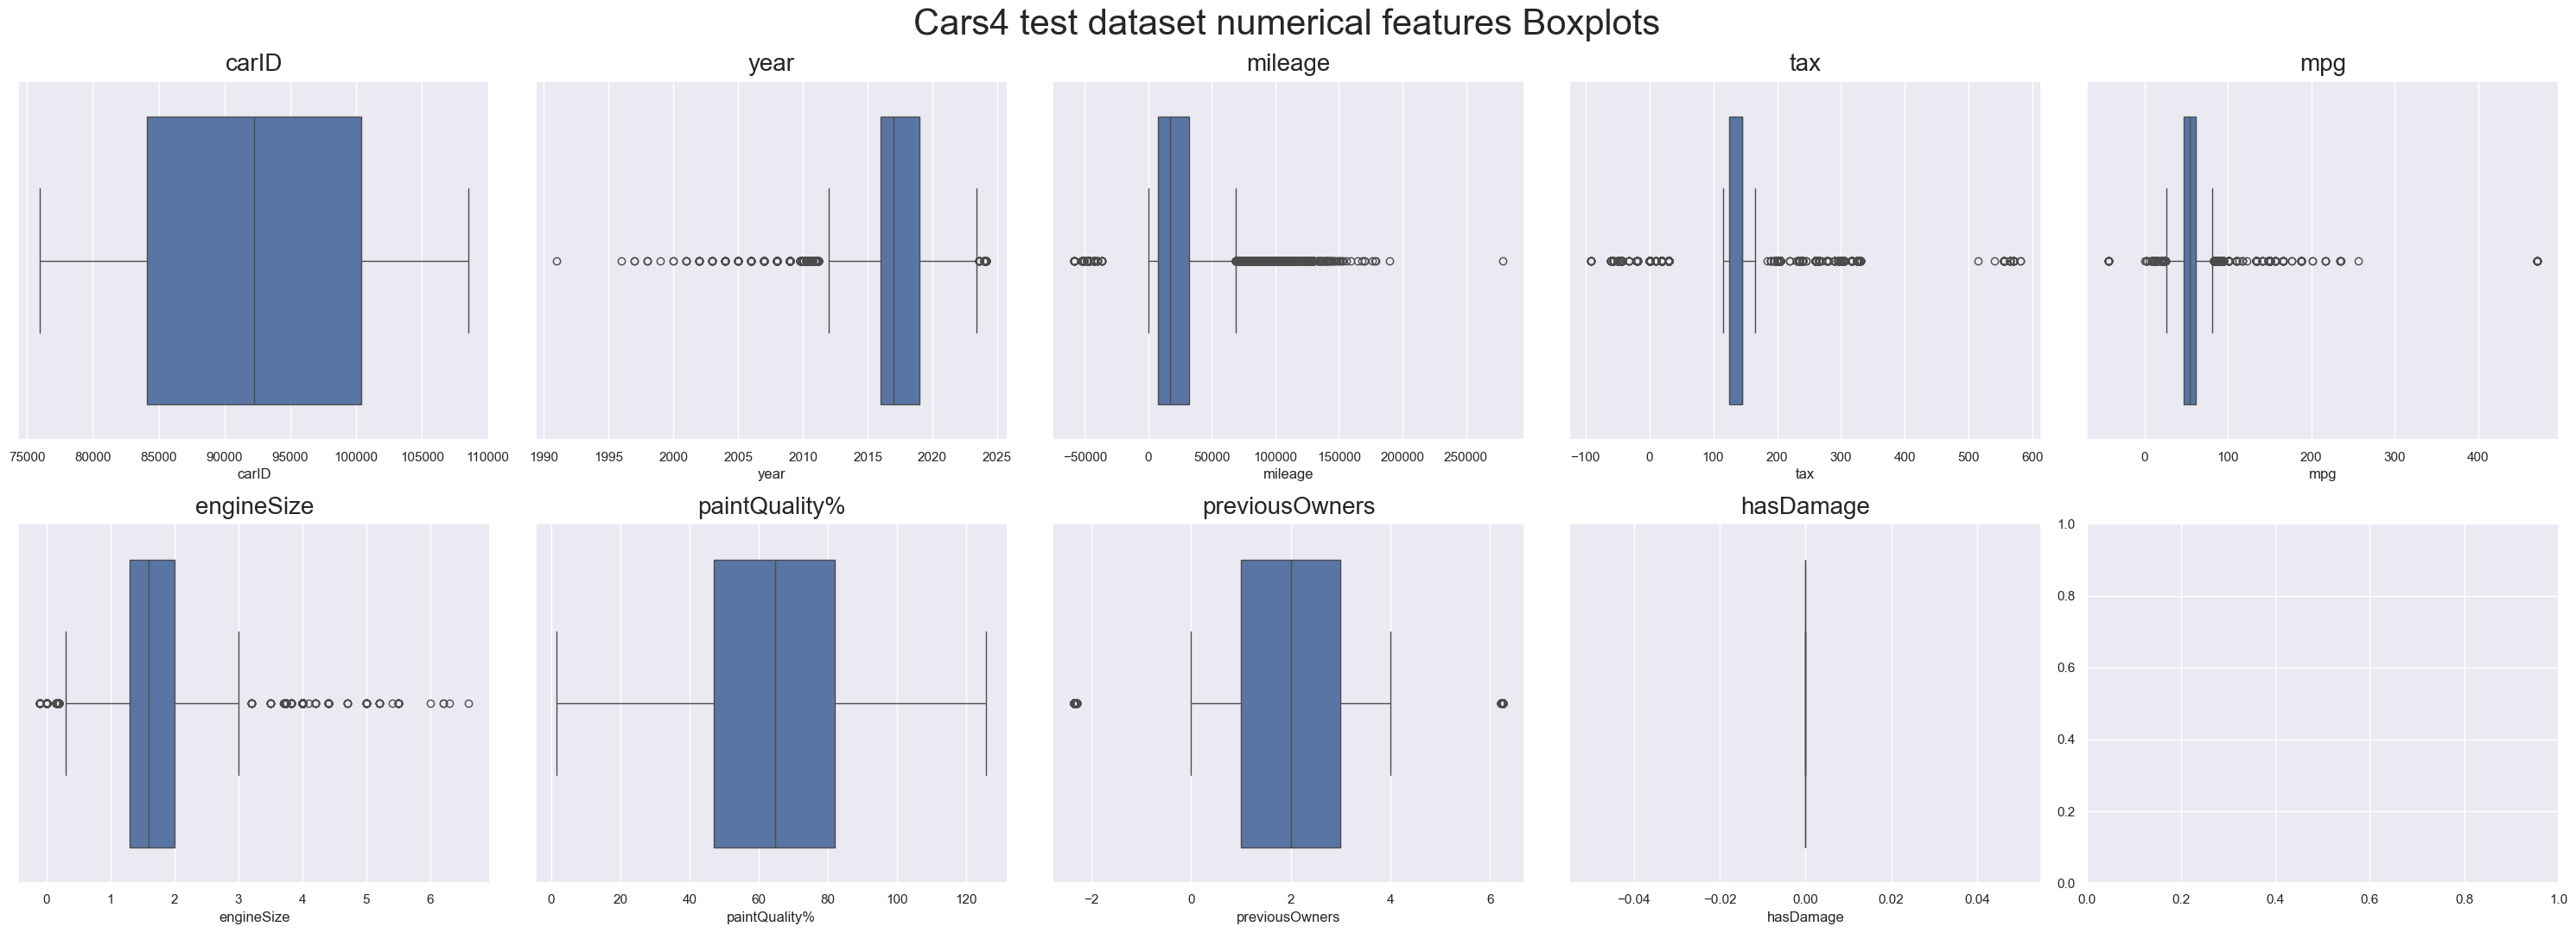

In [41]:
# do the same for the test data

numerical_test_car_data = test_car_data_cp.select_dtypes(exclude="object")
numerical_test_car_data_cols = numerical_test_car_data.columns

sns.set()

# create individual axes for each one of the boxplots 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 11), tight_layout=True) 

# Iterate over each one of the elements and plot their boxplots
for ax, feature in zip(axes.flatten(), numerical_test_car_data_cols):
    sns.boxplot(x=test_car_data_cp[feature], ax=ax)
    ax.set_title(feature, fontsize=20, pad=8)

plt.suptitle("Cars4 test dataset numerical features Boxplots", fontsize=30)    

plt.show()

# podemos estar criar uma função para não estarmos sempre a repetir o código

We are going to apply the same mask in the test data

In [42]:
test_cars_mask = (
    (test_car_data_cp["year"] >= 2005)
    &
    (test_car_data_cp["mileage"].between(0, 150_000))
    &
    (test_car_data_cp["tax"].between(0, 300))
    &
    (test_car_data_cp["mpg"].between(0, 150))
    &
    (test_car_data_cp["engineSize"].between(0, 5))
    &
    (test_car_data_cp["previousOwners"] >= 0)
)


test_cars_filter_out = test_car_data_cp[test_cars_mask]
test_cars_filter_out.head()

# podemos criar uma função que faz isto

,carID,Brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,89856,Hyundai,I30,2022.878006,Automatic,30700.0,Petrol,205.0,41.5,1.6,61.0,3.0,0.0
2,80886,BMW,2 Series,2016.000000,Automatic,36792.0,Petrol,125.0,51.4,1.5,94.0,2.0,0.0
3,100174,Opel,Grandland,2019.000000,Manual,5533.0,Petrol,145.0,44.1,1.2,77.0,1.0,0.0
4,81376,BMW,1 Series,2019.000000,Semi-Automatic,9058.0,Diesel,150.0,51.4,2.0,45.0,4.0,0.0
5,85391,Ford,Fiesta,2018.000000,Manual,29626.0,Petrol,145.0,65.7,1.0,64.0,1.0,0.0


In [43]:
print('Percentage of test data kept after manually removing outliers:', np.round(test_cars_filter_out.shape[0] / test_car_data_cp.shape[0], 4))

Percentage of test data kept after manually removing outliers: 0.971


##### We only remove a total of around 3% rows of the test data

#### Data enconding

We need to change the categorical data into numerical because the model only accepts numerical inputs. For this task we are going to use the different preprocessing methods from skicitlearn.

-> For the brand, transmission and fuelType we can use the OneHotEncoder because the number fo different brands, transmission and types of fuels is low so the creation columns for each new category isn't enough to cause the curse of dimensionality.

-> For the models, we can't use the OneHotEncoder beacuse of the curse of dimensionality, beacuse we were creating a significant amount of new columns. For these reason we are going to use a frequency encoder that maps each category to its frequency in the data. We choose this model because has low likage risk. 

In [44]:
# separate the columns for ohe (onehotencoder) and frequency enconder

ohe_cols = ["Brand", "transmission", "fuelType"]
freq_col = "model"

# 1 fit the encoders on train dataset
frequency_encoder = ce.CountEncoder(cols=[freq_col], normalize=True)
frequency_encoder.fit(train_cars_filter_out[freq_col])


one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False)
one_hot_encoder.fit(train_cars_filter_out[ohe_cols])

# 2a)transform train/test dataset (frequency)
train_model_freq = frequency_encoder.transform(train_cars_filter_out[[freq_col]])[freq_col].rename("model_freq")
test_model_freq  = frequency_encoder.transform(test_cars_filter_out[[freq_col]])[freq_col].rename("model_freq")

# 2b) One-hot for Brand/transmission/fuelType
train_ohe = one_hot_encoder.transform(train_cars_filter_out[ohe_cols])
test_ohe  = one_hot_encoder.transform(test_cars_filter_out[ohe_cols])

ohe_names = one_hot_encoder.get_feature_names_out(ohe_cols)

df_train_ohe = pd.DataFrame(train_ohe, columns=ohe_names, index=train_cars_filter_out.index)
df_test_ohe  = pd.DataFrame(test_ohe,  columns=ohe_names, index=test_cars_filter_out.index)

# 3) Final encoded DataFrames
drop_cols = ohe_cols + [freq_col]

df_car_train_encoded = pd.concat(
    [train_cars_filter_out.drop(columns=drop_cols), df_train_ohe, train_model_freq],
    axis=1
)

df_car_test_encoded = pd.concat(
    [test_cars_filter_out.drop(columns=drop_cols), df_test_ohe, test_model_freq],
    axis=1
)

In [45]:
df_car_train_encoded["year"]= df_car_train_encoded["year"].astype("int64")

In [46]:
df_car_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73799 entries, 0 to 75972
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   carID                        73799 non-null  int64  
 1   year                         73799 non-null  int64  
 2   price                        73799 non-null  int64  
 3   mileage                      73799 non-null  float64
 4   tax                          73799 non-null  float64
 5   mpg                          73799 non-null  float64
 6   engineSize                   73799 non-null  float64
 7   paintQuality%                73799 non-null  float64
 8   previousOwners               73799 non-null  float64
 9   hasDamage                    73799 non-null  float64
 10  Brand_BMW                    73799 non-null  float64
 11  Brand_Ford                   73799 non-null  float64
 12  Brand_Hyundai                73799 non-null  float64
 13  Brand_Mercedes       

In [47]:
df_car_test_encoded["year"]= df_car_test_encoded["year"].astype("int64")

In [48]:
df_car_test_encoded["year"].unique()

array([2022, 2016, 2019, 2018, 2017, 2011, 2015, 2023, 2014, 2020, 2013,
       2010, 2024, 2008, 2012, 2009, 2007, 2006, 2005])

In [49]:
df_car_test_encoded.head()

,carID,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,...,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
0,89856,2022,30700.0,205.0,41.5,1.6,61.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.004946
2,80886,2016,36792.0,125.0,51.4,1.5,94.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.011287
3,100174,2019,5533.0,145.0,44.1,1.2,77.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.005176
4,81376,2019,9058.0,150.0,51.4,2.0,45.0,4.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.017792
5,85391,2018,29626.0,145.0,65.7,1.0,64.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.059228


### Importante!!!! Verificar todos os datatypes

#### Data scaling

We should scale our features because we are using L1/L2-regularized models, which can be very influence by the unscaled features, penalizing them unevenly.

In [50]:
# slipt into X_train, y_train and X_test
feature_cols = [col for col in df_car_train_encoded.columns if col not in ["price", "carID"]]

X_car_train = df_car_train_encoded[feature_cols]
y_car_train = df_car_train_encoded["price"]

X_car_test = df_car_test_encoded.reindex(columns=feature_cols, fill_value=0.0)

In [51]:
X_car_train.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
0,2016,28421.000000,145.0,11.417268,2.0,63.0,4.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.044011
1,2019,4589.000000,145.0,47.900000,1.5,50.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.019052
2,2019,3624.000000,145.0,40.900000,1.5,56.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.007141
4,2019,1000.000000,145.0,42.800000,1.5,97.0,3.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.011287
5,2014,101153.348285,30.0,65.700000,2.0,74.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.021599


In [52]:
scaler = MinMaxScaler(feature_range=(0, 1))

#fit and transform the training and only transform the test data
train_car_enc_scaled = scaler.fit_transform(X_car_train)
test_car_enc_scaled = scaler.transform(X_car_test)

X_train_enc_scaled = pd.DataFrame(train_car_enc_scaled, columns=X_car_train.columns, index=X_car_train.index) 
X_test_enc_scaled = pd.DataFrame(test_car_enc_scaled, columns=X_car_test.columns, index=X_car_test.index) 

In [53]:
X_train_enc_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'Brand_BMW', 'Brand_Ford',
       'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda',
       'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol', 'model_freq'],
      dtype='object')

In [54]:
X_test_enc_scaled.columns

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%',
       'previousOwners', 'hasDamage', 'Brand_BMW', 'Brand_Ford',
       'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda',
       'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen',
       'transmission_Manual', 'transmission_Other',
       'transmission_Semi-Automatic', 'transmission_Unkown',
       'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol', 'model_freq'],
      dtype='object')

In [55]:
X_train_enc_scaled.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
0,0.578947,0.189468,0.483333,0.069900,0.4,0.495026,0.639144,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.479404
1,0.736842,0.030587,0.483333,0.317073,0.3,0.390149,0.159786,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.207441
2,0.736842,0.024153,0.483333,0.269648,0.3,0.438554,0.639144,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.077661
4,0.736842,0.006660,0.483333,0.282520,0.3,0.769318,0.479358,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.122841
5,0.473684,0.674353,0.100000,0.437669,0.4,0.583767,0.000000,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235199


In [56]:
X_test_enc_scaled.head()

,year,mileage,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,Brand_BMW,Brand_Ford,...,Brand_Volkswagen,transmission_Manual,transmission_Other,transmission_Semi-Automatic,transmission_Unkown,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,model_freq
0,0.894737,0.204661,0.683333,0.273713,0.32,0.478891,0.479358,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.053743
2,0.578947,0.245275,0.416667,0.340786,0.30,0.745116,0.319572,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.122841
3,0.736842,0.036880,0.483333,0.291328,0.24,0.607969,0.159786,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.056253
4,0.736842,0.060380,0.500000,0.340786,0.40,0.349812,0.639144,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.193710
5,0.684211,0.197501,0.483333,0.437669,0.20,0.503093,0.159786,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.645209


### Part 3: Feature Selection

For the the feature selection part we can use different methods: filter methods, wrapper methods and embedded methods:

-> filter methods are especially helpful for making an initial screening of the datasets. However, due to their simplicity (they aren't based on a model) they are less affective that wrapper and embedded methods. Due to this reason, once possivel pipeline is to pass the features to different wrapper and embedded methods (one of each) and them selection the features that are more important based on theses methods.

-> For the wrpper methods we can use Recursive Feature Elimination (RFE) or even RFECV

-> Fot the embedded method we can use the Lasso Regression.

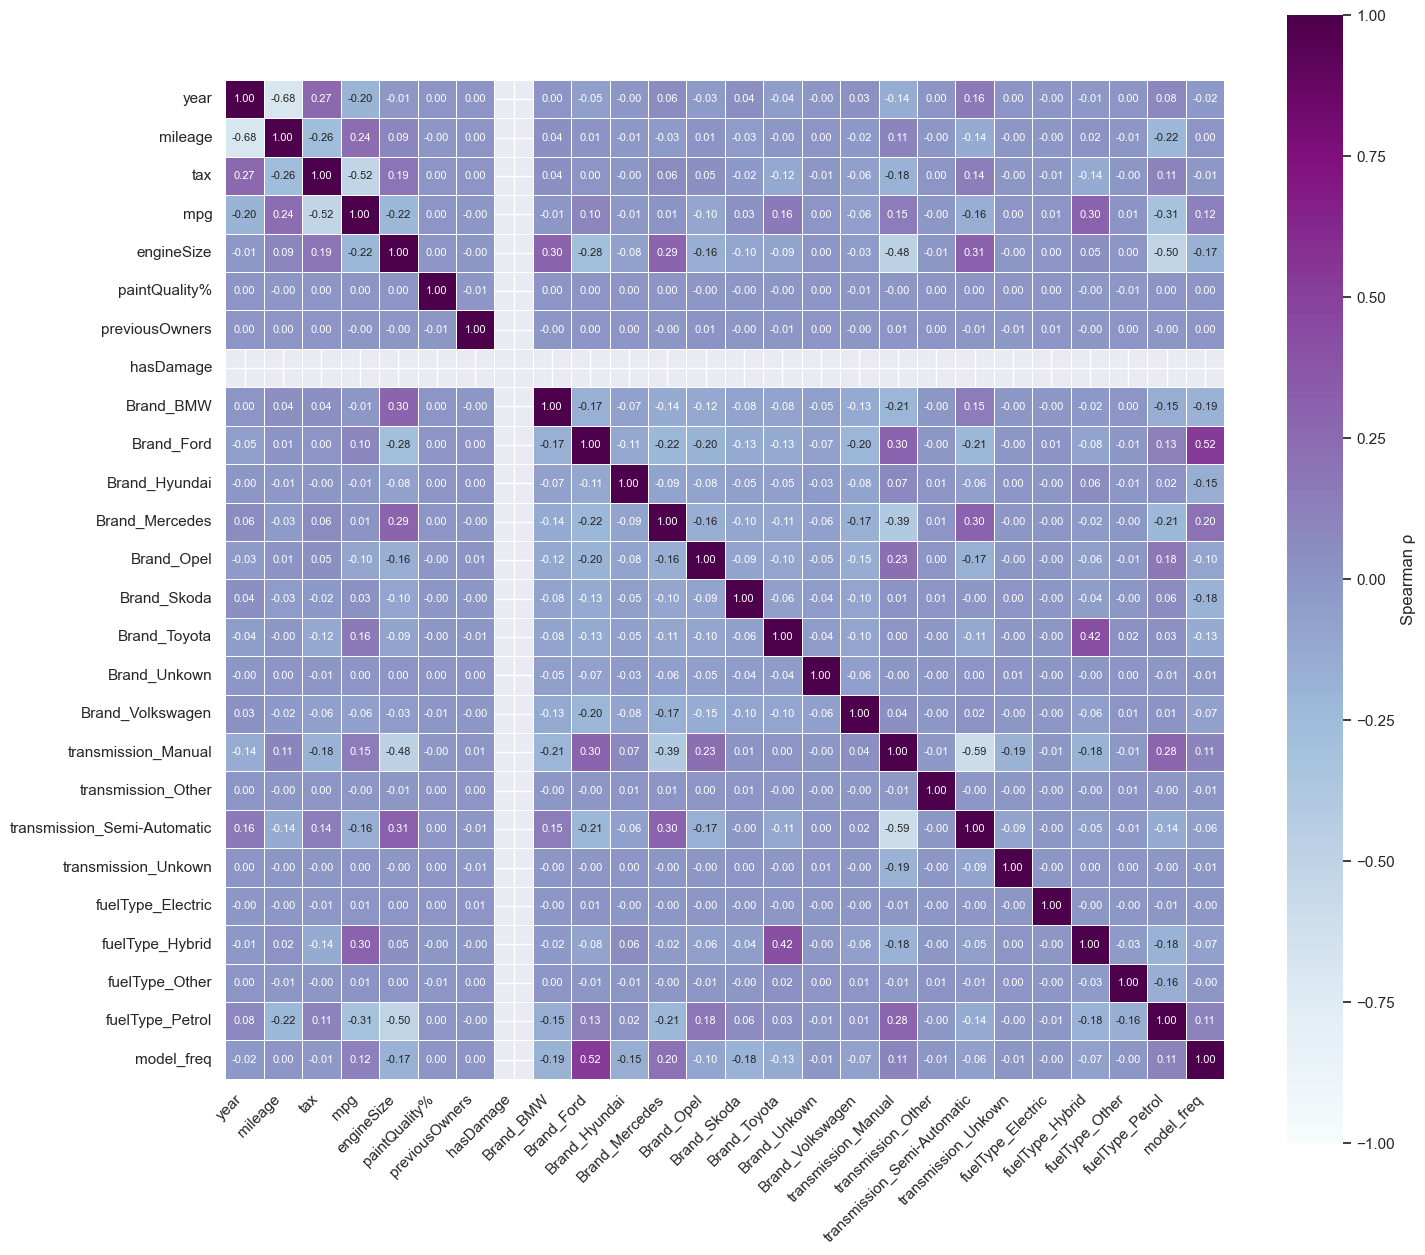

In [57]:
# Fiter method (Spearman correlation)
correlation = X_train_enc_scaled.corr() # default method is pearson correlation

plt.figure(figsize=(15, 15))
sns.heatmap(
    correlation, cmap="BuPu", vmin=-1, vmax=1,
    annot=True, fmt=".2f", annot_kws={"size":8},
    cbar_kws={"shrink":0.8, "label":"Spearman ρ"},
    linewidths=0.5, linecolor="white", square=True
)
plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

From the Correltion matrix it doesn't seems that we have redundant variants (variants with a very high absolute correlation). So we don´t need to drop any features.

-> The HasDamage feature doesn't have any correlation because is a column only composed of zeros, so the correlations are zero across features.

In [101]:
# wrapper method (RFECV)

# the model we are going to use is Random Forrest Regressor
    
estimator = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=1)   

rfecv = RFECV(
    estimator=estimator, 
    step=3, # In each step 3 features are removed
    cv=KFold(n_splits=4, shuffle=True, random_state=42), # split training data into 4 folds and randomly shuffle the rows before folding 
    scoring="neg_root_mean_squared_error", # higher scoring is better (less negative)
    min_features_to_select=7, # it stops when are only 7 features left
    n_jobs = -1 # -1 means using all processors
)

rfecv.fit(X_train_enc_scaled, y_car_train)

# get the optimal number of features
print("Optimal number of features:", rfecv.n_features_)
selected_mask = rfecv.support_
selected_features = X_train_enc_scaled.columns[selected_mask]
print("Selected features:", list(selected_features))

mean_cv_score = rfecv.cv_results_["mean_test_score"]  # mean score for each feature count (drop 3 features at a time)
print("mean_cv_score:", mean_cv_score)

Exception ignored in: <function ResourceTracker.__del__ at 0x102d05c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104739c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106ca5c60>
Traceback (most recent call last

Optimal number of features: 23
Selected features: ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'Brand_BMW', 'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen', 'transmission_Manual', 'transmission_Semi-Automatic', 'transmission_Unkown', 'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'model_freq']
mean_cv_score: [-2481.54991406 -2444.73757675 -2363.65349834 -2332.87514929
 -2303.1106821  -2285.95578967 -2281.3099923  -2282.39269311]


This mean_cv_score means that the best error (-2281.3099923) -> RMSE ≈ 2,281, corresponds to a difference of 2.3k to the real price of a car.

In [58]:
# try RFE with the same estimator 

estimator = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=1)
cv = KFold(n_splits=3, shuffle=True, random_state=42)
scoring = "neg_root_mean_squared_error"

range_features = np.arange(1,len(X_train_enc_scaled.columns)+1)
scores = []

for k in range_features:
    rfe = RFE(estimator=estimator, n_features_to_select=k, step=5)
    # cross-validation on training data 
    cv_score = cross_val_score(rfe, X_train_enc_scaled, y_car_train, cv=cv, scoring=scoring, n_jobs=-1).mean()
    scores.append(cv_score)
    print(f"k={k:>2}  mean CV (neg-RMSE) = {cv_score:.4f}")

# pick the best number of features
best_number_features = range_features[int(np.argmax(scores))]
print("Best number of features:", best_number_features)

# refit RFE on train data with best_k and extract features
rfe_best = RFE(estimator=estimator, n_features_to_select=best_number_features, step=3)
rfe_best.fit(X_train_enc_scaled, y_car_train)
selected_features = X_train_enc_scaled.columns[rfe_best.support_]
print("Selected features:", list(selected_features))

k= 1  mean CV (neg-RMSE) = -7770.1718


Exception ignored in: <function ResourceTracker.__del__ at 0x105165c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106d75c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k= 2  mean CV (neg-RMSE) = -6223.8015


Exception ignored in: <function ResourceTracker.__del__ at 0x1033d5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k= 3  mean CV (neg-RMSE) = -4086.0468


Exception ignored in: <function ResourceTracker.__del__ at 0x106c15c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104b2dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106de1c60>
Traceback (most recent call last

k= 4  mean CV (neg-RMSE) = -3876.0045
k= 5  mean CV (neg-RMSE) = -2904.3842


Exception ignored in: <function ResourceTracker.__del__ at 0x103a65c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103865c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102bfdc60>
Traceback (most recent call last

k= 6  mean CV (neg-RMSE) = -2493.5984


Exception ignored in: <function ResourceTracker.__del__ at 0x103479c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104b65c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106d0dc60>
Traceback (most recent call last

k= 7  mean CV (neg-RMSE) = -2449.9194


Exception ignored in: <function ResourceTracker.__del__ at 0x106e65c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106f61c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k= 8  mean CV (neg-RMSE) = -2473.4890


Exception ignored in: <function ResourceTracker.__del__ at 0x1225adc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104bc5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10355dc60>
Traceback (most recent call last

k= 9  mean CV (neg-RMSE) = -2449.5202


Exception ignored in: <function ResourceTracker.__del__ at 0x102cc5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=10  mean CV (neg-RMSE) = -2425.0297


Exception ignored in: <function ResourceTracker.__del__ at 0x102acdc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105179c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=11  mean CV (neg-RMSE) = -2402.6578


Exception ignored in: <function ResourceTracker.__del__ at 0x11a0d1c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=12  mean CV (neg-RMSE) = -2393.2890


Exception ignored in: <function ResourceTracker.__del__ at 0x107f65c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104065c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102875c60>
Traceback (most recent call last

k=13  mean CV (neg-RMSE) = -2379.7628


Exception ignored in: <function ResourceTracker.__del__ at 0x105375c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=14  mean CV (neg-RMSE) = -2370.5284


Exception ignored in: <function ResourceTracker.__del__ at 0x103365c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107459c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=15  mean CV (neg-RMSE) = -2361.0386


Exception ignored in: <function ResourceTracker.__del__ at 0x106d61c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=16  mean CV (neg-RMSE) = -2353.5502
k=17  mean CV (neg-RMSE) = -2342.2408


Exception ignored in: <function ResourceTracker.__del__ at 0x104911c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1135e5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=18  mean CV (neg-RMSE) = -2336.5619


Exception ignored in: <function ResourceTracker.__del__ at 0x1037e9c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105ac5c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=19  mean CV (neg-RMSE) = -2329.9865


Exception ignored in: <function ResourceTracker.__del__ at 0x104065c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=20  mean CV (neg-RMSE) = -2329.2577


Exception ignored in: <function ResourceTracker.__del__ at 0x1050e1c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=21  mean CV (neg-RMSE) = -2327.7773


Exception ignored in: <function ResourceTracker.__del__ at 0x106bddc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x103165c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=22  mean CV (neg-RMSE) = -2324.6286
k=23  mean CV (neg-RMSE) = -2324.4243


Exception ignored in: <function ResourceTracker.__del__ at 0x106e35c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=24  mean CV (neg-RMSE) = -2324.4229
k=25  mean CV (neg-RMSE) = -2324.1971


Exception ignored in: <function ResourceTracker.__del__ at 0x104d99c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10343dc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes


k=26  mean CV (neg-RMSE) = -2324.1620
Best number of features: 26
Selected features: ['year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage', 'Brand_BMW', 'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen', 'transmission_Manual', 'transmission_Other', 'transmission_Semi-Automatic', 'transmission_Unkown', 'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Other', 'fuelType_Petrol', 'model_freq']


In [69]:
# Embedded method with Lasso Regression

lasso_reg = LassoCV()

lasso_reg.fit(X_train_enc_scaled, y_car_train)

coefficient = pd.Series(lasso_reg.coef_, index = X_train_enc_scaled.columns)

print(coefficient.sort_values())
important_features = [coef for coef, val in coefficient.items() if not np.isclose(val, 0.0, atol=1e-6)]
print("Important features:", important_features)

features_to_discard = [coef for coef, val in coefficient.items() if np.isclose(val, 0.0, atol=1e-6)]
print("Features to discard:", features_to_discard)

mpg                           -22950.404618
mileage                       -14610.929780
Brand_Opel                     -7109.023638
Brand_Hyundai                  -5815.596333
Brand_Toyota                   -5752.347138
Brand_Skoda                    -4554.197456
Brand_Ford                     -3721.833906
Brand_Volkswagen               -3070.169952
Brand_Unkown                   -2894.892137
transmission_Manual            -2116.853407
Brand_BMW                      -1348.363620
tax                            -1183.049997
transmission_Unkown            -1024.288105
fuelType_Petrol                 -666.534012
model_freq                      -252.204764
paintQuality%                   -124.753081
hasDamage                          0.000000
previousOwners                     0.000000
transmission_Other                 0.000000
fuelType_Electric                 -0.000000
fuelType_Other                     0.000000
Brand_Mercedes                   163.760056
transmission_Semi-Automatic     

In [80]:
index = [col for col in X_train_enc_scaled.columns]

In [75]:
data = {
    "RFECV": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep"],
    "RFE": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep"],
    "Lasso": ["Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Discard", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Keep", "Discard", "Keep", "Keep", "Discard", "Keep", "Discard", "Keep", "Keep"]
}

In [79]:
df_feature_selection = pd.DataFrame(
    data,
    index = index
)

df_feature_selection

,RFECV,RFE,Lasso
year,Keep,Keep,Keep
mileage,Keep,Keep,Keep
tax,Keep,Keep,Keep
mpg,Keep,Keep,Keep
engineSize,Keep,Keep,Keep
paintQuality%,Keep,Keep,Keep
previousOwners,Keep,Keep,Discard
hasDamage,Discard,Keep,Discard
Brand_BMW,Keep,Keep,Keep
Brand_Ford,Keep,Keep,Keep


-> For feature selection the metric we are going to use is: if the feature across the 3 models implemented have more discards that keeps than we discard that feature, if the feature as more keeps that discards than we keep that feature.

Based on that metric, the features thar we are going to keep are:
'year', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%','Brand_BMW', 'Brand_Ford', 'Brand_Hyundai', 'Brand_Mercedes', 'Brand_Opel', 'Brand_Skoda', 'Brand_Toyota', 'Brand_Unkown', 'Brand_Volkswagen', 'transmission_Manual', 'transmission_Semi-Automatic', 'transmission_Unkown', 'fuelType_Electric', 'fuelType_Hybrid', 'fuelType_Petrol' and 'model_freq'. 

### Part 4: Model Evaluation